Epoch 0, Loss: 6.53228
Epoch 2000, Loss: 0.04101
Epoch 4000, Loss: 0.04088
Epoch 6000, Loss: 0.04062
Epoch 8000, Loss: 0.03496


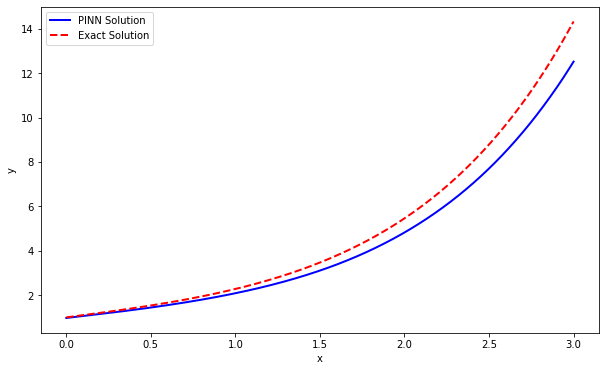

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
        self.act = nn.Tanh()
        self.softplus = nn.Softplus()  # Ensure positive output
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        x = self.softplus(x)
        return x

# Training function
def train_pinn(model, x_ic, y_ic, x_col, epochs=10000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Initial condition loss
        y_ic_pred = model(x_ic)
        loss_ic = torch.mean((y_ic_pred - y_ic) ** 2)
        
        # Equation residual loss
        y_col_pred = model(x_col)
        dydx = torch.autograd.grad(
            outputs=y_col_pred, inputs=x_col,
            grad_outputs=torch.ones_like(y_col_pred),
            create_graph=True
        )[0]
        rhs = y_col_pred - (x_col / y_col_pred)
        residual = dydx - rhs
        loss_eq = torch.mean(residual ** 2)
        
        total_loss = loss_ic + loss_eq
        total_loss.backward()
        optimizer.step()
        
        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.5f}')
    return model

# Generate training data
x_max = 3.0
num_col_points = 1000
x_col = torch.rand(num_col_points, 1) * x_max
x_col.requires_grad = True

# Initial condition
x_ic = torch.tensor([[0.0]], dtype=torch.float32)
y_ic = torch.tensor([[1.0]], dtype=torch.float32)

# Initialize and train the model
model = PINN()
model = train_pinn(model, x_ic, y_ic, x_col, epochs=10000, lr=0.001)

# Testing and plotting
x_test = torch.linspace(0, x_max, 1000).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy()

# Analytical solution
def exact_solution(x):
    return np.sqrt(x + 0.5 + 0.5 * np.exp(2 * x))

x_test_np = x_test.numpy().flatten()
y_exact = exact_solution(x_test_np)

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(10, 6))
plt.plot(x_test_np, y_pred, 'b-', label='PINN Solution', linewidth=2)
plt.plot(x_test_np, y_exact, 'r--', label='Exact Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_04.csv', index=False)
print("pinn_04.csv")

R2_pinn: 0.94553874751465, mae_pinn: 0.5354178547859192, rmse_pinn: 0.7213554382324219, inf_norm_pinn: 1.8082733154296875
数据已保存至 pinn_04.csv
